In [1]:


import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile
import skimage
from scipy import ndimage as nd
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:


BASE_PATH = "../input/hubmap-kidney-segmentation/"
TRAIN_PATH = os.path.join(BASE_PATH, "train")



In [3]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [4]:


df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub



,id,predicted
0,b9a3865fc,NaN
1,b2dc8411c,NaN
2,26dc41664,NaN
3,c68fe75ea,NaN
4,afa5e8098,NaN


In [5]:


df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)



,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
1,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
11,0486052bb.tiff,34937,25784,0486052bb-anatomical-structure.json,0486052bb.json,67177,White,Not Hispanic or Latino,Male,31,106.1,180.3,32.6,Right,80,20
0,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45


# EDA

In [6]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"test/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    n_cols = 4
    n_rows = 4
    col_start = 0
    col_w = 2500
    row_start = 0
    row_w = 2500
    for i in range(n_cols):
        for j in range(n_rows):
            plt.subplot(n_cols, n_rows, n_rows * i + j + 1)
            sub_image = image[
                col_start + i * col_w : col_start + (i + 1) * col_w, 
                row_start + j * row_w : row_start + (j + 1) * row_w, 
                :
            ]
            sub_mask = mask[
                col_start + i * col_w : col_start + (i + 1) * col_w, 
                row_start + j * row_w : row_start + (j + 1) * row_w, 
            ]
            plt.imshow(sub_image)
            plt.imshow(sub_mask, cmap="hot", alpha=0.5)
            plt.axis("off")
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    plt.show()

In [7]:


small_ids = [
    "0486052bb"
]
small_images = []
small_masks = []

for small_id in small_ids:
    tmp_image, tmp_mask = read_image(small_id, scale=5, verbose=0)
    small_images.append(tmp_image)
    small_masks.append(tmp_mask)



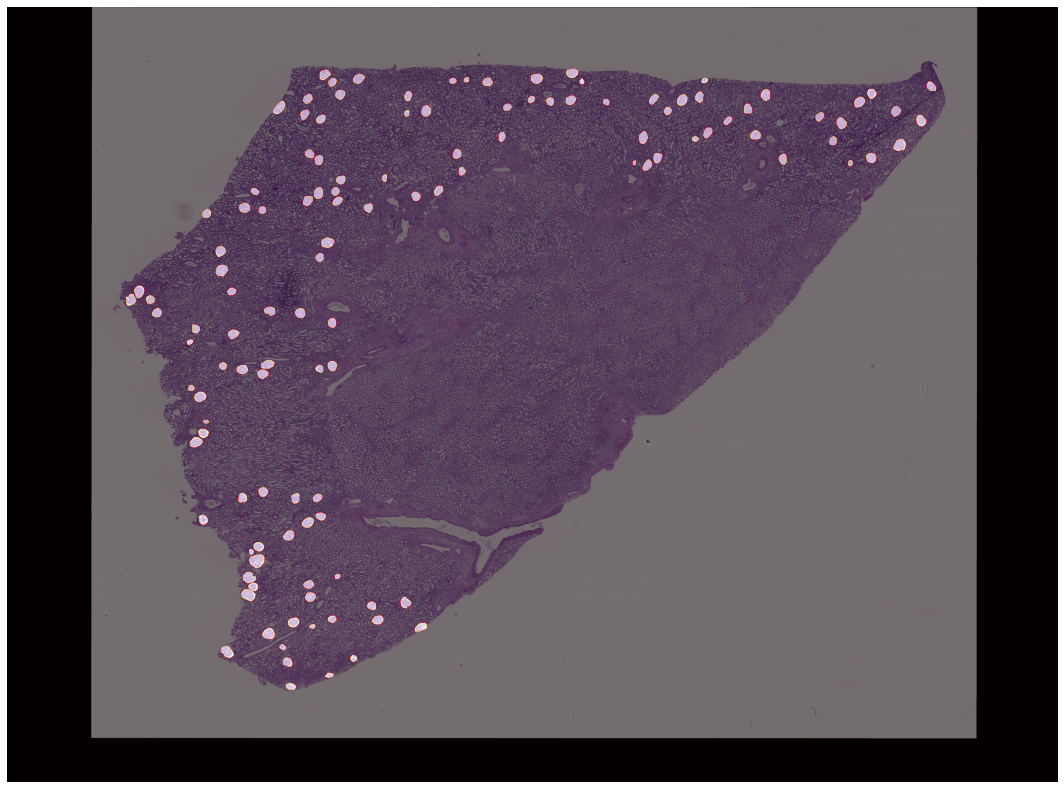

In [8]:


plt.figure(figsize=(64, 64))
for ind, (tmp_id, tmp_image, tmp_mask) in enumerate(zip(small_ids, small_images, small_masks)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="hot", alpha=0.5)
    plt.axis("off")



In [66]:
def getSingleFTU(mask):
    '''
    divides a mask for one pic into many masks each containing single FTU mask
    not used now
    '''
    labels, nlabels = nd.label(mask)
    label_masks = []
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        #label_masks.append(label_mask)
        yield label_mask
def getFTUs(image,mask):
    '''
    from an image and a mask, get list of images of FTUs
    '''
    ftus = []
    labels, nlabels = nd.label(mask)
    for label_ind, label_coords in enumerate(nd.find_objects(labels)):
        cell = image[label_coords]
        ftus.append(cell)
    return ftus

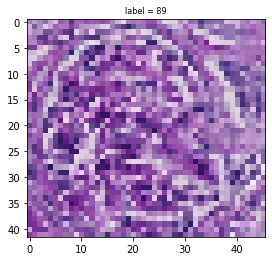

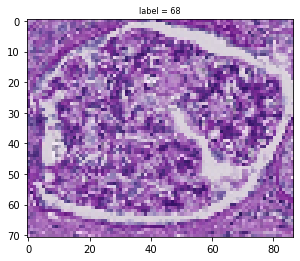

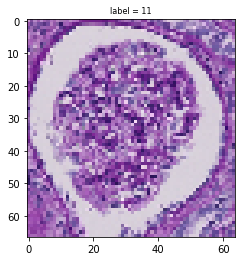

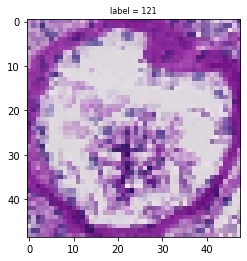

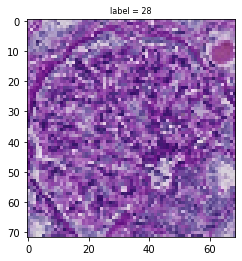

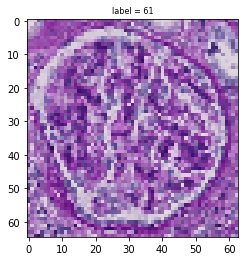

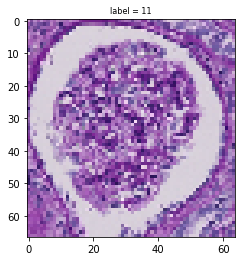

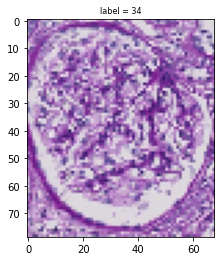

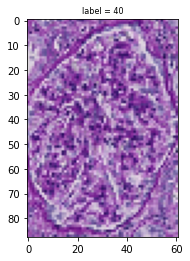

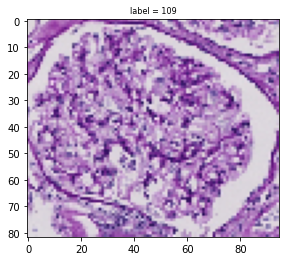

In [88]:
#plot random selection of FTUs from an image
indices = np.random.randint(len(ftus), size=(10))
ftus_selection = np.array(ftus)[indices]

for i,image in zip(indices,ftus_selection):
    plt.figure()
    plt.imshow(image)
    plt.title('label = {}'.format(i), fontsize=8)